
## _Importing packages_


In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"



## Problem Statement

#### _Self-driving car application, making a object detection model using ""YOLO"" algorithm with techniques such as bounding boxes, non-max supression and intersection over union techniques to achieve higher accuarcy._


## YOLO

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

<a name='2-1'></a>
### 2.1 - Model Details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen for you (to cover the 80 classes), and stored in the file './model_data/yolo_anchors.txt'
* The dimension for anchor boxes is the second to last dimension in the encoding: $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  


 using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, you'll flatten the last two dimensions of the shape (19, 19, 5, 85) encoding, so the output of the Deep CNN is (19, 19, 425).

 Flattening the last two last dimensions<br> </center></caption>

#### Class score

Now, for each box (of each cell) you'll compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.



#### Non-Max suppression
 the only boxes plotted are ones for which the model had assigned a high probability, but there will be still too many boxes. To reduce the algorithm's output to a much smaller number of detected objects.  

To do so, uding **non-max suppression**. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score. Meaning, the box is not very confident about detecting a class, either due to the low probability of any object, or low probability of this particular class.
- Select only one box when several boxes overlap with each other and detect the same object.

In [2]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes """

    box_scores = box_confidence * box_class_probs

    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    
    box_classes = tf.math.argmax(box_scores, axis = -1)
    box_class_scores = tf.math.reduce_max(box_scores, axis = -1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
   
    filtering_mask = box_class_scores >= threshold
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
       scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
     
    return scores, boxes, classes

<a name='2-3'></a>
### 2.3 - Non-max Suppression

Even after filtering by thresholding over the class scores, you still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
### iou

Implement `iou()` 

Some hints:
- This code uses the convention that (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) is the lower-right corner. In other words, the (0,0) origin starts at the top left corner of the image. As x increases, you move to the right.  As y increases, you move down.
- For this exercise, a box is defined using its two corners: upper left $(x_1, y_1)$ and lower right $(x_2,y_2)$, instead of using the midpoint, height and width. This makes it a bit easier to calculate the intersection.
- To calculate the area of a rectangle, multiply its height $(y_2 - y_1)$ by its width $(x_2 - x_1)$. Since $(x_1,y_1)$ is the top left and $x_2,y_2$ are the bottom right, these differences should be non-negative.
- To find the **intersection** of the two boxes $(xi_{1}, yi_{1}, xi_{2}, yi_{2})$: 
    - Feel free to draw some examples on paper to clarify this conceptually.
    - The top left corner of the intersection $(xi_{1}, yi_{1})$ is found by comparing the top left corners $(x_1, y_1)$ of the two boxes and finding a vertex that has an x-coordinate that is closer to the right, and y-coordinate that is closer to the bottom.
    - The bottom right corner of the intersection $(xi_{2}, yi_{2})$ is found by comparing the bottom right corners $(x_2,y_2)$ of the two boxes and finding a vertex whose x-coordinate is closer to the left, and the y-coordinate that is closer to the top.
    - The two boxes **may have no intersection**.  You can detect this if the intersection coordinates you calculate end up being the top right and/or bottom left corners of an intersection box.  Another way to think of this is if you calculate the height $(y_2 - y_1)$ or width $(x_2 - x_1)$ and find that at least one of these lengths is negative, then there is no intersection (intersection area is zero).  
    - The two boxes may intersect at the **edges or vertices**, in which case the intersection area is still zero.  This happens when either the height or width (or both) of the calculated intersection is zero.




In [4]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """


    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    xi1 = np.maximum(box1[0], box2[0])
    yi1 = np.maximum(box1[1], box2[1])
    xi2 = np.minimum(box1[2], box2[2])
    yi2 = np.minimum(box1[3], box2[3])
    inter_width = xi2 - xi1
    inter_height = yi2 - yi1
    inter_area = max(inter_height,0)*max(inter_width,0)
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1_y2- box1_y1)*(box1_x2- box1_x1)
    box2_area =  (box2_y2 - box2_y1)*(box2_x2 - box2_x1)
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area/union_area
    
    
    
    return iou


###  yolo_non_max_suppression

Implement `yolo_non_max_suppression()` using TensorFlow. TensorFlow has two built-in functions that are used to implement non-max suppression.

**Reference documentation**: 

- [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)
```
tf.image.non_max_suppression(
    boxes,
    scores,
    max_output_size,
    iou_threshold=0.5,
    name=None
)
```
Note that in the version of TensorFlow used here, there is no parameter `score_threshold` (it's shown in the documentation for the latest version) so trying to set this value will result in an error message: *got an unexpected keyword argument `score_threshold`.*

- [tf.gather()](https://www.tensorflow.org/api_docs/python/tf/gather)
```
keras.gather(
    reference,
    indices
)
```

In [6]:

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
"""    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()

    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    
    nms_indices = tf.image.non_max_suppression(
        boxes,
          scores,
          max_boxes,
          iou_threshold= iou_threshold,
          name=None
        )
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
            
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    

    
    return scores, boxes, classes

### Wrapping Up the Filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions you've just implemented. 

### yolo_eval

Implement `yolo_eval()` which takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There's just one last implementational detail you have to know. There're a few ways of representing boxes, such as via their corners or via their midpoint and height/width. YOLO converts between a few such formats at different times, using the following functions (which are provided): 

```python
boxes = yolo_boxes_to_corners(box_xy, box_wh) 
```
which converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) to fit the input of `yolo_filter_boxes`
```python
boxes = scale_boxes(boxes, image_shape)
```
YOLO's network was trained to run on 608x608 images. If you are testing this data on a different size image -- for example, the car detection dataset had 720x1280 images -- this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  


In [8]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


### Test YOLO Pre-trained Model on Images

Using a pre-trained model and test it on the car detection dataset by drive.ai.

### Defining Classes, Anchors and Image Shape

You're trying to detect 80 classes, and are using 5 anchor boxes. The information on the 80 classes and 5 boxes is gathered in two files: "coco_classes.txt" and "yolo_anchors.txt". You'll read class names and anchors from text files. The car detection dataset has 720x1280 images, which are pre-processed into 608x608 images.

In [17]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608,608) # Same as yolo_model input layer size

### Loading a Pre-trained Model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. Loading an existing pre-trained Keras YOLO model stored in "yolo.h5". These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but are simply referred to as "YOLO" in this notebook.


In [12]:
yolo_model = load_model("model_data/yolo.h5")

This loads the weights of a trained YOLO model. Here's a summary of the layers your model contains:

In [13]:
yolo_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 38, 38, 512)  2048       ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 38, 38, 512)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 38, 38, 256)  131072      ['leaky_re_lu_8[0][0]']          
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 38, 38, 256)  1024       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
          

 conv2d_20 (Conv2D)             (None, 38, 38, 64)   32768       ['leaky_re_lu_12[0][0]']         
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 19, 19, 1024  0           ['batch_normalization_18[0][0]'] 
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 38, 38, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_19 (Conv2D)             (None, 19, 19, 1024  9437184     ['leaky_re_lu_18[0][0]']         
                                )                                                                 
          



**Reminder**: This model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) into a tensor of shape (m, 19, 19, 5, 85) .

### Convert Output of the Model to Usable Bounding Box Tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. You will need to call `yolo_head` to format the encoding of the model you got from `yolo_model` into something decipherable:

yolo_model_outputs = yolo_model(image_data) 
yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
The variable `yolo_outputs` will be defined as a set of 4 tensors that you can then use as input by your yolo_eval function. If you are curious about how yolo_head is implemented, you can find the function definition in the file `keras_yolo.py`. The file is also located in your workspace in this path: `yad2k/models/keras_yolo.py`.


### Filtering Boxes

`yolo_outputs` gave you all the predicted boxes of `yolo_model` in the correct format. To perform filtering and select only the best boxes, you will call `yolo_eval`, which you had previously implemented, to do so:

    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

<a name='3-5'></a>
### 3.5 - Run the YOLO on an Image

Let the fun begin! You will create a graph that can be summarized as follows:

`yolo_model.input` is given to `yolo_model`. The model is used to compute the output `yolo_model.output`
`yolo_model.output` is processed by `yolo_head`. It gives you `yolo_outputs`
`yolo_outputs` goes through a filtering function, `yolo_eval`. It outputs your predictions: `out_scores`, `out_boxes`, `out_classes`.

Now, we have implemented for you the `predict(image_file)` function, which runs the graph to test YOLO on an image to compute `out_scores`, `out_boxes`, `out_classes`.

The code below also uses the following function:

    image, image_data = preprocess_image( image_file, model_image_size = (608, 608))
which opens the image file and scales, reshapes and normalizes the image. It returns the outputs:

    image: a python (PIL) representation of your image used for drawing boxes. We won't need to use it.
    image_data: a numpy-array representing the image. This will be the input to the CNN.

In [14]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 10 boxes for test.jpg
car 0.89 (366, 299) (745, 648)
car 0.80 (762, 282) (942, 412)
car 0.75 (159, 303) (346, 440)
car 0.70 (947, 324) (1280, 704)
car 0.68 (705, 279) (786, 351)
bus 0.67 (5, 267) (220, 407)
car 0.60 (925, 285) (1045, 374)
car 0.45 (336, 296) (377, 335)
car 0.38 (965, 273) (1023, 292)
traffic light 0.35 (681, 195) (692, 215)


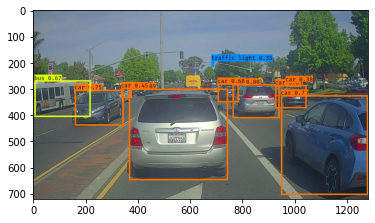

In [16]:
out_scores, out_boxes, out_classes = predict("test.jpg")

The model runned abovd is actually able to detect 80 different classes listed in "coco_classes.txt". To test the model on your own images:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the cell above code
    4. Run the code and see the output of the algorithm!

If you were to run your session in a for loop over all your images. Here's what you would get:


<caption><center> Predictions of the YOLO model on pictures taken from a camera while driving around the Silicon Valley <br> Thanks to <a href="https://www.drive.ai/">drive.ai</a> for providing this dataset! </center></caption>

<a name='4'></a>
## 4 - Summary for YOLO

- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output. 

<font color='blue'>
    
**What you should remember**:
    
- YOLO is a state-of-the-art object detection model that is fast and accurate
- It runs an input image through a CNN, which outputs a 19x19x5x85 dimensional volume. 
- The encoding can be seen as a grid where each of the 19x19 cells contains information about 5 boxes.
- You filter through all the boxes using non-max suppression. Specifically: 
    - Score thresholding on the probability of detecting a class to keep only accurate (high probability) boxes
    - Intersection over Union (IoU) thresholding to eliminate overlapping boxes
- Because training a YOLO model from randomly initialized weights is non-trivial and requires a large dataset as well as lot of computation, previously trained model parameters were used in this exercise. If you wish, you can also try fine-tuning the YOLO model with your own dataset, though this would be a fairly non-trivial exercise. 

<a name='5'></a>
## 5 - References

The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's GitHub repository. The pre-trained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 

### Car detection dataset

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. Thanks to Brody Huval, Chih Hu and Rahul Patel for  providing this data. 